## Head

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import sidetable
import datetime
import matplotlib.pyplot as plt
import functools

from typing import List, Union, Optional

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import causalml
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.rlearner as rlearner
import causalml.inference.meta.tlearner as tlearner



sklearn.tree._tree.TreeBuilder size changed, may indicate binary incompatibility. Expected 72 from C header, got 80 from PyObject


In [4]:
import pylift
import catboost as cb
import lightgbm as lgb

from sklearn.metrics import roc_auc_score

## Lib

In [5]:
import pylift_utils

In [6]:
def compute_receipts_features(
    receipts: pd.DataFrame,
    date_to: datetime.date,
    num_days: int,
) -> pd.DataFrame:
    date_to = datetime.datetime.combine(date_to, datetime.datetime.min.time())
    date_from = date_to - datetime.timedelta(days=num_days)
    date_mask = (receipts['transaction_datetime'] >= date_from) & (receipts['transaction_datetime'] < date_to)
    
    features = (
        receipts
        .loc[date_mask]
        .assign(points_spent=lambda d: d['regular_points_spent'] + d['express_points_spent'])
        .assign(points_spent_flag=lambda d: (d['points_spent'] < 0).astype(int))
        .assign(express_points_spent_flag=lambda d: (d['express_points_spent'] < 0).astype(int))
        .groupby(by=['client_id'])
        .agg({
            "transaction_id": "count",
            "purchase_sum": ["sum", "max", "min", "mean", "median"],
            "regular_points_spent": ["sum", "max"],
            "express_points_spent": ["sum", "max"],
            "transaction_datetime": ["min", "max"],
            "trn_sum_from_red": ["sum", "max", "mean"],
            "points_spent_flag": ["sum"],
            "express_points_spent_flag": ["sum"],
        })
        .assign(
            mean_time_interval=lambda d: (
                (d['transaction_datetime']['max'] - d['transaction_datetime']['min'])
                / (d['transaction_id']['count'] - 1)
            ).apply(lambda delta: delta.total_seconds() / (24 * 3600))
        )
        .assign(
            time_since_last=lambda d: (
                date_to - d['transaction_datetime']['max']
            ).apply(lambda delta: delta.total_seconds() / (24 * 3600))
        )
    )

    column_names = [
        f'rec__{col}__{agg}__{num_days}d' if agg else f'rec__{col}__{num_days}d'
        for col, agg in features.columns
    ]
    features.columns = column_names
    features.reset_index(inplace=True)

    return features

## Load'n'cook

### load

In [7]:
purchases = dd.read_parquet('data/purchases.parquet')

In [8]:
campaigns = pd.read_csv('data/campaigns.csv')

In [9]:
client_profile = pd.read_csv('data/client_profile.csv')

### first glance

In [10]:
purchases_head = purchases.head(1000)

In [11]:
purchases_head.head(20)

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
__null_dask_index__,,,,,,,,,,,,,
0,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,30531,1.0,77.0,NaN
1,162,2655010,2018-12-24 15:50:50,0.8,0.0,0.0,0.0,167.00,560,668,1.0,70.0,NaN
2,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,15558,1.0,28.0,NaN
3,162,2655010,2018-12-24 15:50:50,0.8,0.0,0.0,0.0,167.00,560,24637,1.0,57.0,NaN
4,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,31933,2.0,162.0,NaN
5,162,7921345,2018-12-06 13:24:59,1.8,0.0,0.0,0.0,368.00,560,30708,2.0,120.0,NaN
6,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,30708,1.0,60.0,NaN
7,162,7556682,2018-12-17 11:56:33,0.7,0.0,0.0,0.0,140.00,472,31772,1.0,81.0,NaN
8,162,5681805,2018-12-26 11:35:21,2.1,0.0,0.0,0.0,434.97,560,12790,0.0,63.0,NaN


In [12]:
purchases_head.stb.missing()

,missing,total,percent
trn_sum_from_red,968,1000,96.8
client_id,0,1000,0.0
transaction_id,0,1000,0.0
transaction_datetime,0,1000,0.0
regular_points_received,0,1000,0.0
express_points_received,0,1000,0.0
regular_points_spent,0,1000,0.0
express_points_spent,0,1000,0.0
purchase_sum,0,1000,0.0
store_id,0,1000,0.0


In [13]:
campaigns.head(20)

,client_id,treatment_flg,treatment_date,target_purchases_sum,target_purchases_count,target_campaign_points_spent
0,162,0,2019-03-21,195.00,1,0.0
1,359,1,2019-03-21,1298.93,3,300.0
2,600,1,2019-03-21,1224.17,1,-0.0
3,1042,1,2019-03-21,313.18,2,300.0
4,1080,1,2019-03-21,0.00,0,-0.0
5,1590,0,2019-03-21,1199.87,1,0.0
6,1607,1,2019-03-21,429.00,2,-0.0
7,1730,0,2019-03-21,414.89,3,0.0
8,1772,0,2019-03-21,1380.20,2,0.0
9,1812,1,2019-03-21,243.00,1,-0.0


In [14]:
campaigns['treatment_date'].value_counts()

2019-03-21    500000
Name: treatment_date, dtype: int64

In [15]:
campaigns['treatment_flg'].value_counts()

0    250018
1    249982
Name: treatment_flg, dtype: int64

Датасет разделен почти поровну на целевую и контрольную группу

In [16]:
campaigns.stb.missing()

,missing,total,percent
client_id,0,500000,0.0
treatment_flg,0,500000,0.0
treatment_date,0,500000,0.0
target_purchases_sum,0,500000,0.0
target_purchases_count,0,500000,0.0
target_campaign_points_spent,0,500000,0.0


In [17]:
client_profile.shape

(500000, 4)

In [18]:
client_profile.head(20)

,client_id,first_issue_date,age,gender
0,162,2018-07-06 19:36:04,52,F
1,359,2017-07-14 16:27:35,60,M
2,600,2017-10-10 12:22:44,82,M
3,1042,2017-11-26 11:21:29,40,U
4,1080,2018-02-21 19:08:56,21,U
5,1590,2017-06-05 20:45:37,58,M
6,1607,2017-05-19 17:27:57,80,F
7,1730,2017-09-14 16:26:14,69,U
8,1772,2017-07-13 18:56:30,31,U
9,1812,2018-09-27 12:47:29,67,F


In [19]:
client_profile.stb.missing()

,missing,total,percent
client_id,0,500000,0.0
first_issue_date,0,500000,0.0
age,0,500000,0.0
gender,0,500000,0.0


Данные по клиентам: дата первой покупки, возраст, пол (без пропусков)

### cook

#### first features portion

In [20]:
receipts = (
    purchases
    .groupby(by=['client_id', 'transaction_id'])
    .agg({
        'trn_sum_from_red': 'sum',
        'trn_sum_from_iss': 'sum',
        'regular_points_received': 'first',
        'express_points_received': 'first',
        'regular_points_spent': 'first',
        'express_points_spent': 'first',
        'purchase_sum': 'first',
        'store_id': 'first',
        'transaction_datetime': 'first',
    })
    .reset_index()
)

In [21]:
# receipts.to_parquet('data/receipts.parquet')

In [22]:
receipts = pd.read_parquet('data/receipts.parquet')

In [23]:
receipts.head()

,client_id,transaction_id,trn_sum_from_red,trn_sum_from_iss,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,transaction_datetime
0,0,4169120,0.0,804.0,8.0,0.0,0.0,0.0,803.0,81,2019-03-08 10:12:03
1,0,4962998,0.0,1007.0,10.0,0.0,0.0,0.0,1007.0,4557,2018-12-01 07:12:45
2,0,7048393,0.0,419.0,2.0,0.0,0.0,0.0,419.0,81,2019-03-14 15:01:47
3,0,7618050,0.0,575.0,5.7,0.0,0.0,0.0,574.0,12891,2018-12-16 08:56:01
4,1,402585,0.0,700.0,7.0,0.0,0.0,0.0,700.0,3166,2018-12-21 11:08:58


In [24]:
FEATURES_DATE_TO = datetime.date(2019, 3, 19)


def _prepare_data(
    purchases: dd.DataFrame,
    receipts: pd.DataFrame,
    campaigns: pd.DataFrame,
    client_profile: pd.DataFrame,
    features_date_to: datetime.date = FEATURES_DATE_TO
) -> pd.DataFrame:
    
    result_parts = [
        compute_receipts_features(receipts, features_date_to, num_days=60),
        compute_receipts_features(receipts, features_date_to, num_days=15),
        client_profile
    ]
    
    result = campaigns.copy()
    for part in result_parts:
        result = result.merge(part, on='client_id', how='left')  

    return result

In [25]:
data = _prepare_data(
    purchases,
    receipts,
    campaigns,
    client_profile
)

In [26]:
data.shape

(500000, 47)

In [27]:
data.head()

,client_id,treatment_flg,treatment_date,target_purchases_sum,target_purchases_count,target_campaign_points_spent,rec__transaction_id__count__60d,rec__purchase_sum__sum__60d,rec__purchase_sum__max__60d,rec__purchase_sum__min__60d,...,rec__trn_sum_from_red__sum__15d,rec__trn_sum_from_red__max__15d,rec__trn_sum_from_red__mean__15d,rec__points_spent_flag__sum__15d,rec__express_points_spent_flag__sum__15d,rec__mean_time_interval__15d,rec__time_since_last__15d,first_issue_date,age,gender
0,162,0,2019-03-21,195.00,1,0.0,6,1235.00,419.00,15.00,...,0.0,0.0,0.0,0.0,0.0,NaN,4.314039,2018-07-06 19:36:04,52,F
1,359,1,2019-03-21,1298.93,3,300.0,9,2780.41,819.98,59.98,...,0.0,0.0,0.0,0.0,0.0,2.581039,0.512095,2017-07-14 16:27:35,60,M
2,600,1,2019-03-21,1224.17,1,-0.0,17,20985.70,2425.00,358.57,...,624.0,624.0,104.0,1.0,1.0,2.614931,1.582535,2017-10-10 12:22:44,82,M
3,1042,1,2019-03-21,313.18,2,300.0,20,4414.01,594.09,43.00,...,0.0,0.0,0.0,0.0,0.0,2.947917,0.616609,2017-11-26 11:21:29,40,U
4,1080,1,2019-03-21,0.00,0,-0.0,4,1217.00,656.00,57.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02-21 19:08:56,21,U


Собрали признаки клиентов + флаг воздействия. Осталось посчитать целевой признак.

#### profit from client

In [28]:
_columns = [
    'treatment_flg',
    'target_purchases_sum',
    'target_purchases_count',
    'target_campaign_points_spent'
]

data[_columns].head(5)

,treatment_flg,target_purchases_sum,target_purchases_count,target_campaign_points_spent
0,0,195.00,1,0.0
1,1,1298.93,3,300.0
2,1,1224.17,1,-0.0
3,1,313.18,2,300.0
4,1,0.00,0,-0.0


target_purchases_sum - сумма покупок клиента.

В нашем распоряжении нет данных о себестоимости товаров, поэтому **условимся**, что мы продаем все товары с коэффициентом **маржинальности 20%**

Знаем, что стоимость сообщения клиенту составляет 1.5 руб.

In [29]:
MARGIN_RATE = 0.2
POINTS_PER_RUBLE = 10.0
COMMUNICATION_COST = 1.5

In [30]:
data = data.assign(target_profit=lambda d: (
    d['target_purchases_sum'] * MARGIN_RATE
    - d['target_campaign_points_spent'] / POINTS_PER_RUBLE
    - (d['treatment_flg'] == 1).astype(int) * COMMUNICATION_COST
))

In [31]:
_columns = [
    'treatment_flg',
    'target_profit',
    'target_purchases_sum',
    'target_purchases_count',
    'target_campaign_points_spent'
]

data[_columns].head(20)

,treatment_flg,target_profit,target_purchases_sum,target_purchases_count,target_campaign_points_spent
0,0,39.000,195.00,1,0.0
1,1,228.286,1298.93,3,300.0
2,1,243.334,1224.17,1,-0.0
3,1,31.136,313.18,2,300.0
4,1,-1.500,0.00,0,-0.0
5,0,239.974,1199.87,1,0.0
6,1,84.300,429.00,2,-0.0
7,0,82.978,414.89,3,0.0
8,0,276.040,1380.20,2,0.0
9,1,47.100,243.00,1,-0.0


#### historical visit probability

In [32]:
def _compute_historical_visit_probability(
    transaction_datetimes: pd.Series, period: int, date_to: datetime.date
) -> float:
    if len(transaction_datetimes) < 2:
        return 0.0
    dates = transaction_datetimes.dt.date.sort_values()
    diffs = (dates.iloc[1: ].reset_index(drop=True) - dates.iloc[: -1].reset_index(drop=True)).dt.days.values - period + 1
    diffs[np.where(diffs < 0)] = 0
    return 1.0 - diffs.sum() / ((date_to - dates.iloc[0]).days - period + 1)

In [33]:
# Не было в оригинальном ноутбуке
receipts_ = receipts.copy()

In [34]:
receipts_sorted = receipts_.sort_values(by=['client_id', 'transaction_datetime'])

In [35]:
historical_visit_probability_7d = (
    receipts_sorted
    .groupby(by=['client_id'])
    ['transaction_datetime']
    .apply(functools.partial(_compute_historical_visit_probability, period=7, date_to=datetime.date(2019, 3, 20)))
)

invalid value encountered in long_scalars


In [36]:
historical_visit_probability_7d.to_csv('data/historical_visit_probability_7d.csv')

In [37]:
historical_visit_probability_7d = pd.read_csv('data/historical_visit_probability_7d.csv')

In [38]:
data = (
    data
    .merge(
        historical_visit_probability_7d
            .reset_index()
            .rename(columns={'transaction_datetime': 'historical_visit_probability__7d'}),
        on=['client_id'], how='left'
    )
)

In [39]:
data.head()

,client_id,treatment_flg,treatment_date,target_purchases_sum,target_purchases_count,target_campaign_points_spent,rec__transaction_id__count__60d,rec__purchase_sum__sum__60d,rec__purchase_sum__max__60d,rec__purchase_sum__min__60d,...,rec__points_spent_flag__sum__15d,rec__express_points_spent_flag__sum__15d,rec__mean_time_interval__15d,rec__time_since_last__15d,first_issue_date,age,gender,target_profit,index,historical_visit_probability__7d
0,162,0,2019-03-21,195.00,1,0.0,6,1235.00,419.00,15.00,...,0.0,0.0,NaN,4.314039,2018-07-06 19:36:04,52,F,39.000,162,0.602041
1,359,1,2019-03-21,1298.93,3,300.0,9,2780.41,819.98,59.98,...,0.0,0.0,2.581039,0.512095,2017-07-14 16:27:35,60,M,228.286,359,0.376147
2,600,1,2019-03-21,1224.17,1,-0.0,17,20985.70,2425.00,358.57,...,1.0,1.0,2.614931,1.582535,2017-10-10 12:22:44,82,M,243.334,600,0.972973
3,1042,1,2019-03-21,313.18,2,300.0,20,4414.01,594.09,43.00,...,0.0,0.0,2.947917,0.616609,2017-11-26 11:21:29,40,U,31.136,1042,0.928571
4,1080,1,2019-03-21,0.00,0,-0.0,4,1217.00,656.00,57.00,...,NaN,NaN,NaN,NaN,2018-02-21 19:08:56,21,U,-1.500,1080,0.561404


### splits

In [40]:
fit_index, val_index = train_test_split(data.index, test_size=0.5, random_state=185)

### column sets

In [41]:
cols_features_n1 = [
    'rec__transaction_id__count__60d',
    'rec__purchase_sum__sum__60d',
    'rec__purchase_sum__max__60d',
    'rec__purchase_sum__min__60d',
    'rec__purchase_sum__mean__60d',
    'rec__purchase_sum__median__60d',
    'rec__regular_points_spent__sum__60d',
    'rec__regular_points_spent__max__60d',
    'rec__express_points_spent__sum__60d',
    'rec__express_points_spent__max__60d',
    'rec__trn_sum_from_red__sum__60d',
    'rec__trn_sum_from_red__max__60d',
    'rec__trn_sum_from_red__mean__60d',
    'rec__points_spent_flag__sum__60d',
    'rec__express_points_spent_flag__sum__60d',
    'rec__mean_time_interval__60d',
    'rec__time_since_last__60d',
    'age'
]

## Story

In [42]:
_stats = data.loc[fit_index].groupby(by=['treatment_flg'])['target_profit'].mean()
_stats

treatment_flg
0    109.925166
1    109.477460
Name: target_profit, dtype: float64

In [43]:
_stats.loc[1] - _stats.loc[0]

-0.44770657624023613

Средняя прибыль в целевой и контрольной группе. И разница между ними.

### straightforward approach

#### build model

In [44]:
col_target = 'target_profit'
col_treatment = 'treatment_flg'

In [45]:
cols_features = cols_features_n1

In [46]:
model_n1 = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0,
    n_fold=4,
    random_state=165
)

In [47]:
_p_score_const = data.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_scores = pd.Series(data=_p_score_const, index=fit_index)
model_n1.fit(
    X=data.loc[fit_index, cols_features].values,
    treatment=data.loc[fit_index, col_treatment].values,
    y=data.loc[fit_index, col_target].values,
    p=_p_scores
)

In [48]:
_p_score_const

0.49802

_p_score_const - это propensity score. В нашем случае - доля клиентов, у которых treatment = 1 среди всех клиентов

#### evaluate model

In [49]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['score'] = model_n1.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, col_target]]

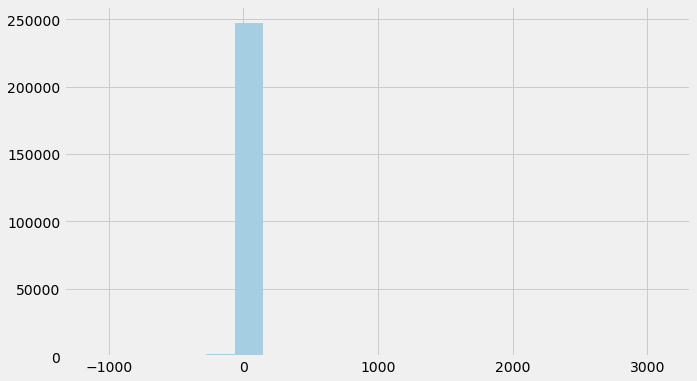

In [50]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=20)
plt.show()

In [51]:
np.percentile(_eval_data['score'], 5)

-7.406786191578747

In [52]:
np.percentile(_eval_data['score'], 95)

2.9073588553108545

Видим, что диапазон значений очень широкий, хотя основная масса сосредоточена около нуля.  
Сузим диапазон.

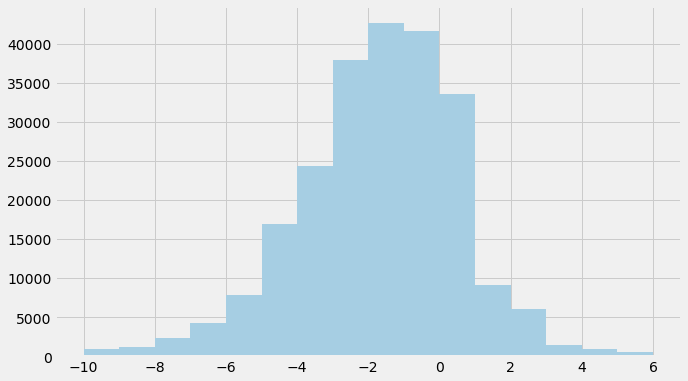

In [53]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], range=(-10.0, 6.0), bins=16)
plt.show()

In [54]:
_eval_data['score'].describe()

count    250000.000000
mean         -0.667256
std          40.298479
min       -1120.561170
25%          -3.166641
50%          -1.502209
75%          -0.091809
max        3108.149650
Name: score, dtype: float64

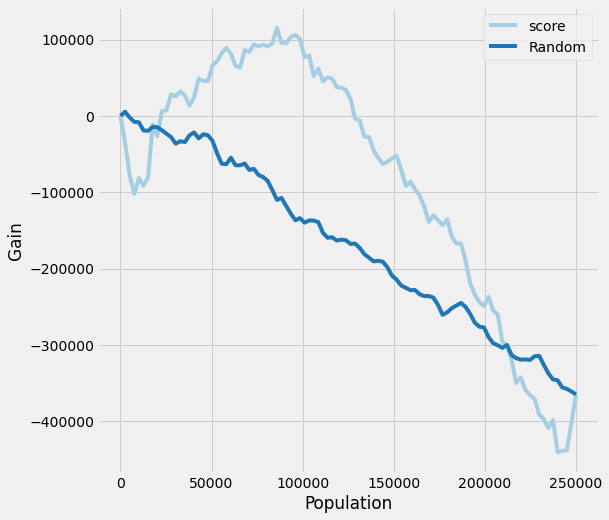

In [55]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

На графике видим, что если делать рассылку на первых 100 тыс. человек из 250 тыс. (первые 40%), то можно получить прибыль около 100 тыс. рублей.  
Рассылка на всех клиентов - мы теряем деньги, а на первых 40% - зарабатываем

#### conclusions

Обратите вниемание, что
* uplift-кривая получается более "шумной", по сравнению с кейсами с предыдущих лекций
* (!) Уже есть вариант модели, который можно использовать в будущих кампаниях (prove of concept)


Но давайте попробуем построить более "простой" (возможно, не ML) подход

* Будет с чем сравнить текущее ML решение
* Решения без ML намного проще внедрить в production

Кроме того, мы пока не понимаем за счет чего мы получили дополнительную прибыль. Что изменилось в поведении клиентов? 

##### cut

! Как интерпретировать получившуюся uplift-модель?

### first decomposition

Разложим CATE на слагаемые

<font size="5">
$$
Up[Y|X] = Up[Z|X] - P(R=1|X,T=1)b - c
$$
</font>

In [56]:
_target_columns = [
    'target_profit',
    'target_purchases_sum',
    'target_purchases_count',
    'target_campaign_points_spent'
]

In [57]:
_stats = data.loc[fit_index].groupby(by=['treatment_flg'])[_target_columns].mean()
_stats

,target_profit,target_purchases_sum,target_purchases_count,target_campaign_points_spent
treatment_flg,,,,
0,109.925166,549.625832,1.333615,0.000000
1,109.477460,585.706543,1.444866,61.638488


In [58]:
print(
    'Up[Y] =',
    _stats.loc[1, 'target_profit'] - _stats.loc[0, 'target_profit']
)

Up[Y] = -0.44770657624023613


In [59]:
print(
    'Up[Z] =',
    MARGIN_RATE * (_stats.loc[1, 'target_purchases_sum'] - _stats.loc[0, 'target_purchases_sum'])
)

Up[Z] = 7.216142265171744


In [60]:
print(
    'P(R = 1|T = 1)b =',
    1 / POINTS_PER_RUBLE * (
        _stats.loc[1, 'target_campaign_points_spent'] - _stats.loc[0, 'target_campaign_points_spent']
    )
)

P(R = 1|T = 1)b = 6.163848841411991


In [61]:
COMMUNICATION_COST

1.5

На тестовых данных мы видим, что:   
    - клиенты из целевой группы принесли в среднем меньше прибыли (это также было видно на графике - при рассылке всем мы теряем деньги)  
    - есть аплифт по марже и он немного превышает аплифт потерь на баллы. Разница этих двух величин в основном определеяет итоговый результат. Сейчас почти всю дополнительную маржу мы раздаем в виде баллов.  

**Главные драйверы** ATE прибыли
* прирост маржи - $Up[Z]$
* затраты на баллы - $P(R = 1|T = 1)b$

<font size="4">   
    <b> Разложение </b> ожидаемого эффекта помогло <b>направить EDA</b>!
</font>

### points redemption

Попробуем прогнозировать

<font size="5">
$$P(R=1|X,T=1)$$
</font>

\- вероятность того, что клиент воспользуется бонусными баллами во время кампании (если их ему дать :) )

**Исходя из формулы**, понимаем, что для построения такой модели нужно **рассматривать** только **тех клиентов, которые получили предложение**

#### build redemption probability model

In [62]:
treated_fit_index = data.loc[fit_index, ['treatment_flg']].query('treatment_flg == 1').index

In [63]:
cols_features = cols_features_n1

In [64]:
red_p_model = lgb.LGBMRegressor()

In [65]:
red_p_model.fit(
    X=data.loc[treated_fit_index, cols_features],
    y=(data.loc[treated_fit_index, 'target_campaign_points_spent'] > 0).astype(int)
)

LGBMRegressor()

In [66]:
treated_val_index = data.loc[val_index, ['treatment_flg']].query('treatment_flg == 1').index

In [67]:
red_p_predictions = red_p_model.predict(data.loc[treated_val_index, cols_features])

In [68]:
pd.Series(red_p_predictions).describe()

count    125477.000000
mean          0.208629
std           0.124862
min          -0.014871
25%           0.115634
50%           0.181788
75%           0.268707
max           1.055199
dtype: float64

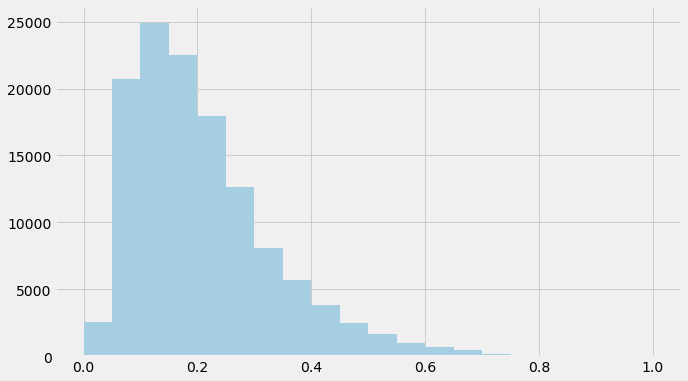

In [69]:
plt.figure(figsize=(10, 6))
plt.hist(red_p_predictions, range=(0.0, 1.0), bins=20)
plt.show()

In [70]:
roc_auc_score(
    (data.loc[treated_val_index, 'target_campaign_points_spent'] > 0).astype(int),
    red_p_predictions
)

0.6947234295868903

Теперь у нас есть модель, предсказывающая вероятность списания бонусов клиентом, если ему эти бонусы начислить.  
ROC_AUC модели около 70%. Не очень много, но лучше, чем ничего.

#### redemption probabilty (scores) VS profit uplift scores

In [71]:
cols_features = cols_features_n1

In [72]:
col_target = 'target_profit'
col_treatment = 'treatment_flg'

In [73]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, col_target, 'target_campaign_points_spent']]
_eval_data['redemption_probabilty_score'] = -red_p_model.predict(_eval_data[cols_features])
_eval_data['profit_uplift_score'] = model_n1.predict(_eval_data[cols_features])
_eval_data['target_campaign_points_spent_flg'] = (_eval_data['target_campaign_points_spent'] > 0).astype(int)
_eval_data = _eval_data.drop(columns=cols_features)

In [74]:
_eval_data['profit_uplift_score_bin'] = pd.qcut(_eval_data['profit_uplift_score'], q=8, duplicates='drop')

Посмотрим на вероятность списать баллы **в разрезе прогнозов uplift-модели** для прибыли.

BTW: Это хороший способ **интерпретации uplift-моделей**!

In [75]:
_pivot = _eval_data.loc[treated_val_index].groupby(by=['profit_uplift_score_bin']).agg(
    {'target_campaign_points_spent_flg': 'mean', 'profit_uplift_score_bin': 'count'}
)
_pivot

,target_campaign_points_spent_flg,profit_uplift_score_bin
profit_uplift_score_bin,,
"(-1120.562, -4.492]",0.325262,16768
"(-4.492, -3.167]",0.263917,14694
"(-3.167, -2.168]",0.228855,15595
"(-2.168, -1.502]",0.196929,15498
"(-1.502, -0.643]",0.180638,15711
"(-0.643, -0.0918]",0.174269,16245
"(-0.0918, 0.881]",0.143065,16496
"(0.881, 3108.15]",0.158673,14470


Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


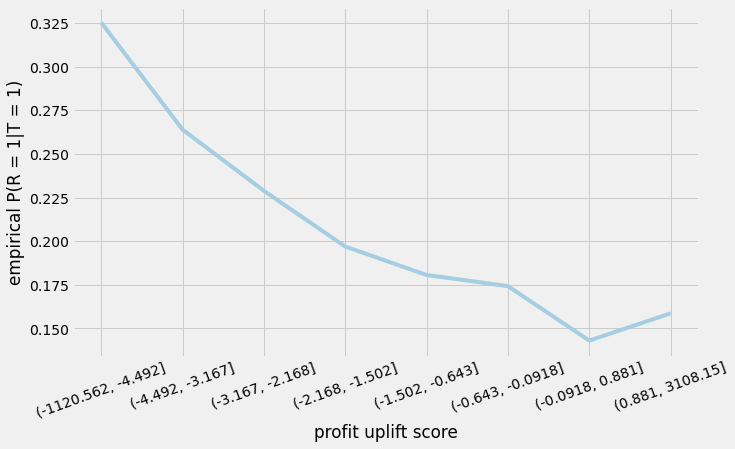

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(_pivot['target_campaign_points_spent_flg'])
plt.xticks(range(len(_pivot.index)), _pivot.index, rotation=20)
plt.xlabel('profit uplift score')
plt.ylabel('empirical P(R = 1|T = 1)')
plt.show()

Мы разбили клиентов на бины по прогнозу аплифта. И теперь смотрим, какая у них вероятность списать баллы.  
Видим, что клиенты с худшим скором аплифта (первые бины) имеют максимальную вероятность списать баллы.  
Это наталкивает на мысль, что при рассылке важно учитывать вероятность списания баллов.

Что, если отсортировать клиентов по прогнозу вероятности списать баллы?

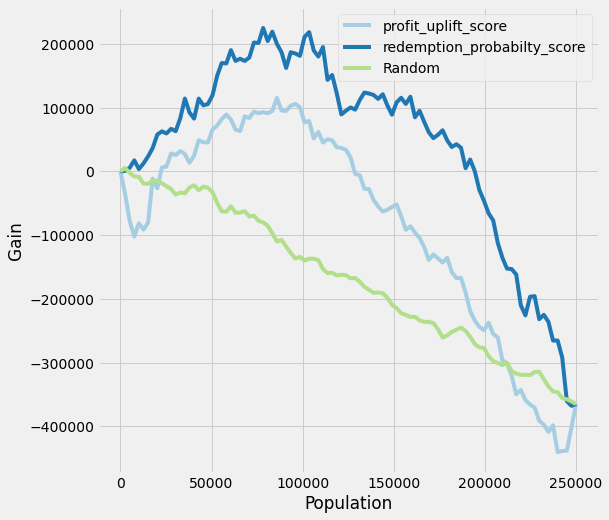

In [77]:
cmetrics.plot_gain(
    _eval_data[[col_treatment, col_target, 'profit_uplift_score', 'redemption_probabilty_score']],
    treatment_col=col_treatment,
    outcome_col=col_target,
)

Видно, что сортируя клиентов не по скору модели, а по вероятности списать бонусные баллы также можно получить положительный результат, если делать рассылку на первых клиентов этой сортировки.

### purchases sum uplift

Вспомним, что на уровне клиента

<font size="5">
$$
Z = QS
$$
</font>

Маржа = кол-во покупок * средняя маржа одной покупки

Пример: клиент совершил 2 покупки в период кампании - на 500 и на 300 руб. В таком случае

Q = 2

S = (500 + 300) * MARGIN_RATE / 2 = 80 (руб.)
 

Посчитаем суммарные показатели Z, Q в разрезе по ЦГ и КГ.

На их основе высчитаем средний (на всю группу!) чек в разрезе по ЦГ и КГ.

In [78]:
_target_columns = [
    'target_profit',
    'target_purchases_sum',
    'target_purchases_count',
]

In [79]:
_stats = data.loc[fit_index].groupby(by=['treatment_flg'])[_target_columns].mean()
_stats['target_average_check'] = _stats['target_purchases_sum'] / _stats['target_purchases_count']
_stats

,target_profit,target_purchases_sum,target_purchases_count,target_average_check
treatment_flg,,,,
0,109.925166,549.625832,1.333615,412.132347
1,109.477460,585.706543,1.444866,405.370933


In [80]:
MARGIN_RATE * (_stats.loc[1, 'target_purchases_sum'] - _stats.loc[0, 'target_purchases_sum'])

7.216142265171744

In [81]:
_stats.loc[1, 'target_purchases_sum'] / _stats.loc[0, 'target_purchases_sum']

1.0656459526258888

In [82]:
_stats.loc[1, 'target_purchases_count'] / _stats.loc[0, 'target_purchases_count']

1.083420471859592

In [83]:
_stats.loc[1, 'target_average_check'] / _stats.loc[0, 'target_average_check']

0.9835940710967047

Видим, что маржа после рассылки выросла на ~ 7 рублей.  
Средняя сумма покупка выросла на ~6%.  
При этом кол-во покупок выросло на ~8%,  
а средний чек упал на ~2%.

Кажется, что выручка меняется **сильнее** от того, что **клиенты чаще ходят в магазин**, нежели от падения среднего чека

Теперь выпишем строгую формулировку разложения

<font size="5">
$$
Up[Z|X] = E[\delta_Q S(0)|X] + E[Q(0) \delta_{S}|X] + E[\delta_Q \delta_{S}|X]
$$
</font>

где 

$Q(1)$, $Q(0)$ - количество покупок клиента в период кампании во вселенной с оффером и без оффера соответственно,

$ \delta_Q = Q(1) - Q(0)$,

$S(1)$, $S(0)$ - средняя маржа (в руб.) покупок клиента в период кампании во вселенной с оффером и без оффера соответственно,

$ \delta_S = S(1) - S(0)$.


Исходя из почитанных ранее чисел, предполагаем, что **главным** слагаемым является 
<font size="4">
$E[\delta_Q S(0)|X]$
</font>

Потому что прирост числа покупок (по модулю) больше чем прирост средней маржи. А последний член будет еще меньше.  

Удостоверимся, что величины $\delta_Q$ и $S(0)$ сильно связаны с прогнозом uplift прибыли.

Сделаем это, рассмотрев показатели в разрезе прогнозов uplift-модели

In [84]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, 'target_purchases_sum', 'target_purchases_count']]
_eval_data['profit_uplift_score'] = model_n1.predict(_eval_data[cols_features])
_eval_data = _eval_data[[
    'target_purchases_sum', 'profit_uplift_score', 'target_purchases_count',
    col_treatment
]]

In [85]:
_eval_data['profit_uplift_score_bin'] = pd.qcut(_eval_data['profit_uplift_score'], q=8, duplicates='drop')

In [86]:
_stats = (
    _eval_data
    .assign(target_margin_sum=lambda d: d['target_purchases_sum'] * MARGIN_RATE)
    .pivot_table(
        index=['profit_uplift_score_bin'],
        columns=[col_treatment],
        values=['target_purchases_sum', 'target_purchases_count', 'target_margin_sum']
    )
)

_stats.loc[:, ('target_margin_per_purchase', 0)] = _stats['target_margin_sum'][0] / _stats['target_purchases_count'][0]
_stats.loc[:, ('target_margin_per_purchase', 1)] = _stats['target_margin_sum'][1] / _stats['target_purchases_count'][1]
_stats['margin_per_purchase_uplift'] = _stats['target_margin_per_purchase'][1] - _stats['target_margin_per_purchase'][0]

_stats['purchases_count_uplift'] = _stats['target_purchases_count'][1] - _stats['target_purchases_count'][0]
_stats['purchases_sum_uplift'] = _stats['target_purchases_sum'][1] - _stats['target_purchases_sum'][0]
_stats['purchases_count_perc_uplift'] = _stats['target_purchases_count'][1] / _stats['target_purchases_count'][0]
_stats['purchases_sum_perc_uplift'] = _stats['target_purchases_sum'][1] / _stats['target_purchases_sum'][0]
_stats

target_margin_sum             target_purchases_count  \
treatment_flg                           0           1                      0   
profit_uplift_score_bin                                                        
(-1120.562, -4.492]            170.564909  180.417076               2.412765   
(-4.492, -3.167]               107.170046  110.549670               1.680529   
(-3.167, -2.168]                90.262499   95.654498               1.349652   
(-2.168, -1.502]                99.765784  102.753579               1.229748   
(-1.502, -0.643]                85.088651   89.913524               1.078355   
(-0.643, -0.0918]               86.541870   93.978538               0.975821   
(-0.0918, 0.881]                73.396477   81.049459               0.738176   
(0.881, 3108.15]               178.225586  185.478805               1.217564   

                                  target_purchases_sum              \
treatment_flg                   1                    0           1   
profit_uplift_score_bin                                              
(-1120.562, -4.492]      2.590410           852.824544  902.085382   
(-4.492, -3.167]         1.807200           535.850231  552.748352   
(-3.167, -2.168]         1.461366           451.312496  478.272489   
(-2.168, -1.502]         1.322880           498.828919  513.767896   
(-1.502, -0.643]         1.151550           425.443253  449.567622   
(-0.643, -0.0918]        1.087104           432.709351  469.892689   
(-0.0918, 0.881]         0.826018           366.982385  405.247294   
(0.881, 3108.15]         1.298963           891.127929  927.394026   

                        target_margin_per_purchase              \
treatment_flg                                    0           1   
profit_uplift_score_bin                                          
(-1120.562, -4.492]                      70.692717   69.648069   
(-4.492, -3.167]                         63.771612   61.171789   
(-3.167, -2.168]                         66.878366   65.455546   
(-2.168, -1.502]                         81.127025   77.674128   
(-1.502, -0.643]                         78.906001   78.080443   
(-0.643, -0.0918]                        88.686212   86.448547   
(-0.0918, 0.881]                         99.429454   98.120642   
(0.881, 3108.15]                        146.378769  142.789865   

                        margin_per_purchase_uplift purchases_count_uplift  \
treatment_flg                                                               
profit_uplift_score_bin                                                     
(-1120.562, -4.492]                      -1.044648               0.177645   
(-4.492, -3.167]                         -2.599823               0.126671   
(-3.167, -2.168]                         -1.422820               0.111714   
(-2.168, -1.502]                         -3.452897               0.093133   
(-1.502, -0.643]                         -0.825558               0.073195   
(-0.643, -0.0918]                        -2.237665               0.111283   
(-0.0918, 0.881]                         -1.308811               0.087842   
(0.881, 3108.15]                         -3.588904               0.081399   

                        purchases_sum_uplift purchases_count_perc_uplift  \
treatment_flg                                                              
profit_uplift_score_bin                                                    
(-1120.562, -4.492]                49.260838                    1.073627   
(-4.492, -3.167]                   16.898121                    1.075376   
(-3.167, -2.168]                   26.959993                    1.082773   
(-2.168, -1.502]                   14.938977                    1.075733   
(-1.502, -0.643]                   24.124369                    1.067877   
(-0.643, -0.0918]                  37.183338                    1.114040   
(-0.0918, 0.881]                   38.264910                    1.118999   
(0.881, 3108.15]                   36

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


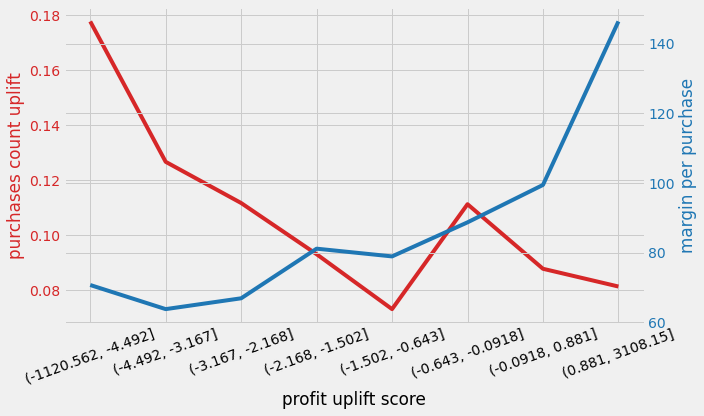

In [87]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('profit uplift score')
ax1.set_ylabel('purchases count uplift', color=color)
ax1.plot(_stats['purchases_count_uplift'], color=color)
plt.xticks(range(len(_stats.index)), _stats.index, rotation=20)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('margin per purchase', color=color)
ax2.plot(_stats['target_margin_per_purchase'][0], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

По оси Х - score uplift-модели, разбитые на бины.  
Видно, что максимальный скор получают клиенты, которые имеют максимальную маржу на чек (синяя линия) и при этом имеют минимальный uplift по количеству покупок (красная линия)

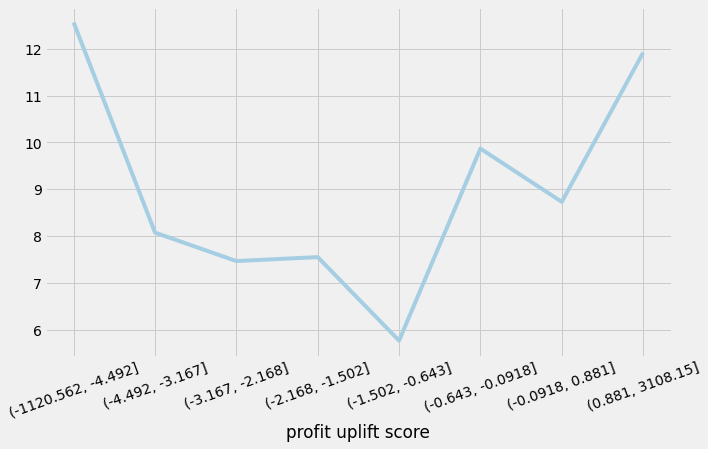

In [88]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('profit uplift score')
ax1.plot(
    (
        _stats['purchases_count_uplift'] * _stats['target_margin_per_purchase'][0]
    )
)
plt.xticks(range(len(_stats.index)), _stats.index, rotation=20)

plt.show()

Если перемножить 2 величины, представленных на предыдущем графике (uplift кол-ва покупок * средняя маржа), то получим такую зависимость от скора uplift-модели.  
Видно, что зависимость немонотонная. Также видно, что диапазон значений широк. А значит значение этого параметра имеет большое значение в прогнозе uplift.

### rough model

Давайте используем все полученные ранее выводы, чтобы построить грубую схему прогноза

Мы пришли к такой формуле разложения CATE "прибыли"

<font size="4">
$$
Up[Y|X] = (E[\delta_Q S(0)|X] + E[Q(0) \delta_{S}|X] + E[\delta_Q \delta_{S}|X]) - P(R=1|X, T = 1)b - c
$$
</font>

Если пренебречь теми слагаемыми, которые кажутся нам "малыми", получим

<font size="4">
$$
\hat{Up}[Y|X] \sim \hat{E}[\delta_Q S(0)|X] - \hat{P}(R=1|X, T = 1)b - c
$$
</font>

Как можно спрогнозировать $\hat{E}[\delta_Q S(0)|X]$?

Давайте попробуем

$$
\hat{E}[\delta_Q S(0)|X] \sim \hat{E}[S(0)|X] \hat{Up}[Q]
$$

где

$\hat{Up}[Q]$ - средний по больнице прирост числа чеков на клиента,

$\hat{E}[S(0)|X]$ - оценка средней прибыли с чека клиента. Можно
* использовать ML
* или, к примеру, взять **среднюю маржу с его покупок** за длинный предшествующий кампании период времени (60 дней)

In [89]:
tmp = data.loc[fit_index].pivot_table(
    values=['target_purchases_count', 'target_purchases_sum'],
    index=[col_treatment]
)
tmp['target_margin_per_purchase'] = MARGIN_RATE * tmp['target_purchases_sum'] / tmp['target_purchases_count']
tmp

,target_purchases_count,target_purchases_sum,target_margin_per_purchase
treatment_flg,,,
0,1.333615,549.625832,82.426469
1,1.444866,585.706543,81.074187


In [90]:
purchases_count_uplift = tmp.loc[1, 'target_purchases_count'] - tmp.loc[0, 'target_purchases_count']

In [91]:
print('Estimate of Up[Q] =', purchases_count_uplift)

Estimate of Up[Q] = 0.11125078299027868


Как можно спрогнозировать $\hat{P}(R = 1|X, T = 1)$?

Заметим, что
   
$$P(R = 1|X, T = 1) = P(R = 1|X, T = 1, Z > 0) P(Z > 0|X, T = 1)$$

Давайте попробуем

$$
\hat{P}(R=1|X, T = 1) \sim \hat{P}(R=1|T = 1, Z > 0) \hat{P}(Z > 0|X, T = 1)
$$

где

$\hat{P}(R=1|T = 1, Z > 0)$ - средняя "по больнице" вероятность списать полученные баллы, при условии, что клиент совершал покупки.

$ \hat{P}(Z > 0|X, T = 1)$ - оценка вероятности того, что клиент совершит покупку в период кампании. Можно 
* использовать ML
* или, к примеру,  взять **долю окон в 7 дней (длительность кампании), в которые клиент совершал покупку**.


In [92]:
treatment_index = data.query(f'{col_treatment} == 1').index
p_redeem_if_buy_rate = (
    (data.loc[treatment_index]['target_campaign_points_spent'] > 0).astype(int).sum()
    / (data.loc[treatment_index]['target_purchases_count'] > 0).astype(int).sum()
)


In [93]:
print('Estimate of P(R=1|T=1,Z>0) =', p_redeem_if_buy_rate)

Estimate of P(R=1|T=1,Z>0) = 0.3259764004068465


Вероятность того, что клиент совершит покупку в течение 7 дней (срок действия акции) была посчитана ранее (в переменной historical_visit_probability_7d)

Соберем итоговый прогноз по формуле

<font size="4">
$$
\hat{Up}[Z|X] \sim \hat{E}[S(0)|X] \hat{Up}[Q] - \hat{P}(R=1|T = 1, Z > 0) \hat{P}(Z > 0|X, T = 1) - c
$$
</font>

In [94]:
data[['historical_visit_probability__7d', 'rec__purchase_sum__mean__60d']].stb.missing()

,missing,total,percent
historical_visit_probability__7d,166,500000,0.0332
rec__purchase_sum__mean__60d,0,500000,0.0000


In [95]:
BENEFIT_RUB = 30.0
prediction = (
    purchases_count_uplift * MARGIN_RATE * data['rec__purchase_sum__mean__60d']
    - data['historical_visit_probability__7d'].fillna(1.0) * p_redeem_if_buy_rate * BENEFIT_RUB
    - COMMUNICATION_COST
)

In [96]:
col_target = 'target_profit'
col_treatment = 'treatment_flg'
_eval_data = data.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['model_score'] = model_n1.predict(_eval_data[cols_features])
_eval_data['rough_score'] = prediction.loc[val_index]
_eval_data = _eval_data[['model_score', 'rough_score', col_treatment, col_target]]

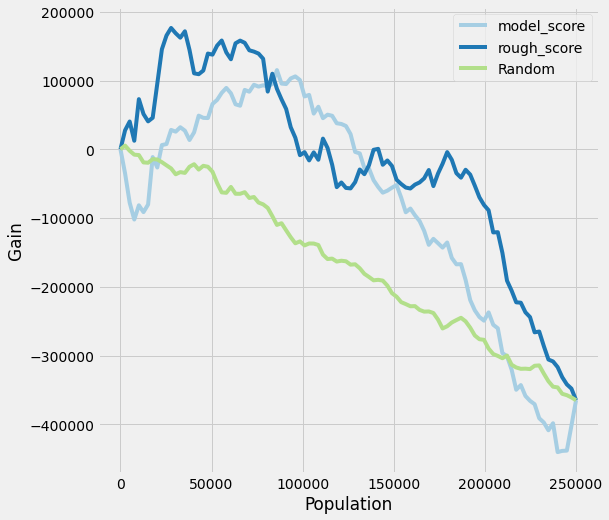

In [97]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

Видим, что грубый подход (со многими упрощениями и без ML) во многом превосходит стандартную uplift-модель на R-learner

Если текущий вариант модели не лучше прогноза по грубой формуле, то нужно 
* либо плотнее заняться улучшением модели
* либо пользоваться прогнозом по грубой формуле



Большой минус грубых подходов - **плохая адаптируемость к изменениям** в среде.Если со временем бОльшую роль в эффекте станут играть другие слагаемые, то такой подход не подстроится к изменению.

**Потребуется ручная работа аналитика** для вывода новых главных факторов

Также можно заметить, что у модели есть проблемы в начале и конце графика (провалы голубой линии)

In [98]:
_eval_data[['model_score', 'rough_score']].describe()

,model_score,rough_score
count,250000.000000,250000.000000
mean,-0.667256,3.386694
std,40.298479,9.442496
min,-1120.561170,-10.907714
25%,-3.166641,-2.591204
50%,-1.502209,1.158572
75%,-0.091809,6.641636
max,3108.149650,273.930789


Хвосты прогнозов модели очень тяжелые. Поэтому можно попытаться построить более робастный вариант модели.

In [99]:
upeval = pylift.eval.UpliftEval(
    treatment=_eval_data[col_treatment],
    outcome=_eval_data[col_target],
    prediction=_eval_data['rough_score'],
    n_bins=10
)

No handles with labels found to put in legend.


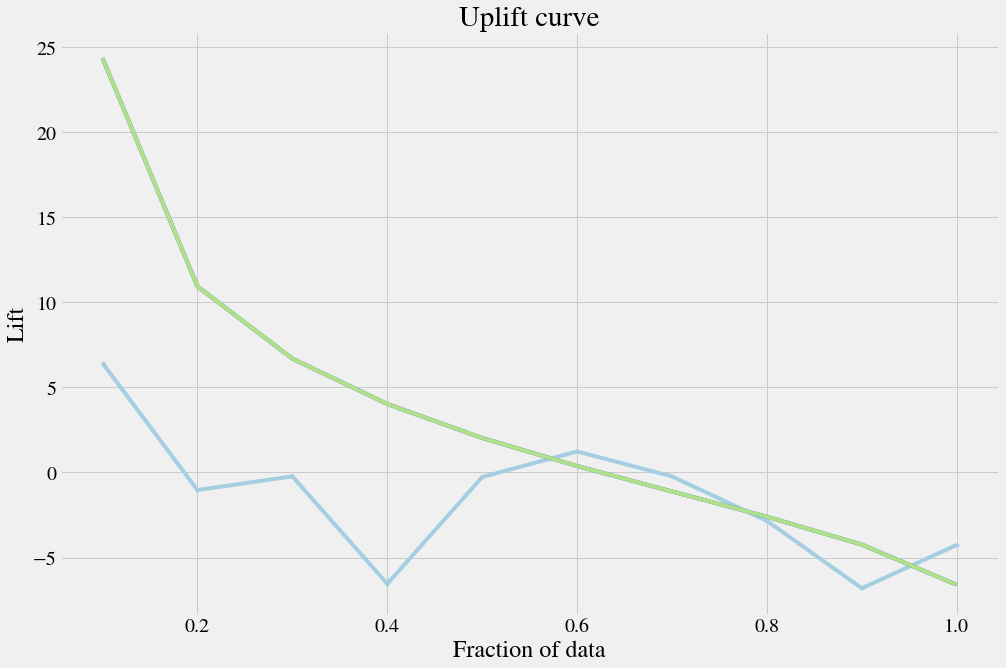

In [100]:
upeval.plot_uplift()
plt.plot(*pylift_utils.plot_uplift_prediction(upeval=upeval, n_bins=10))

Оценка получилась **смещенной** - как и ожидалось, ведь мы ввели не совсем корректные упрощения в формулу.  
Зеленая линия - прогноз грубой модели.  
Голубая линия - реальный аплифт.

Прогнозы грубой модели оказались более оптимистичными для в левой части, то есть там, где грубая модель дает максимальный скор.

In [101]:
upeval = pylift.eval.UpliftEval(
    treatment=_eval_data[col_treatment],
    outcome=_eval_data[col_target],
    prediction=_eval_data['model_score'],
    n_bins=10
)

No handles with labels found to put in legend.


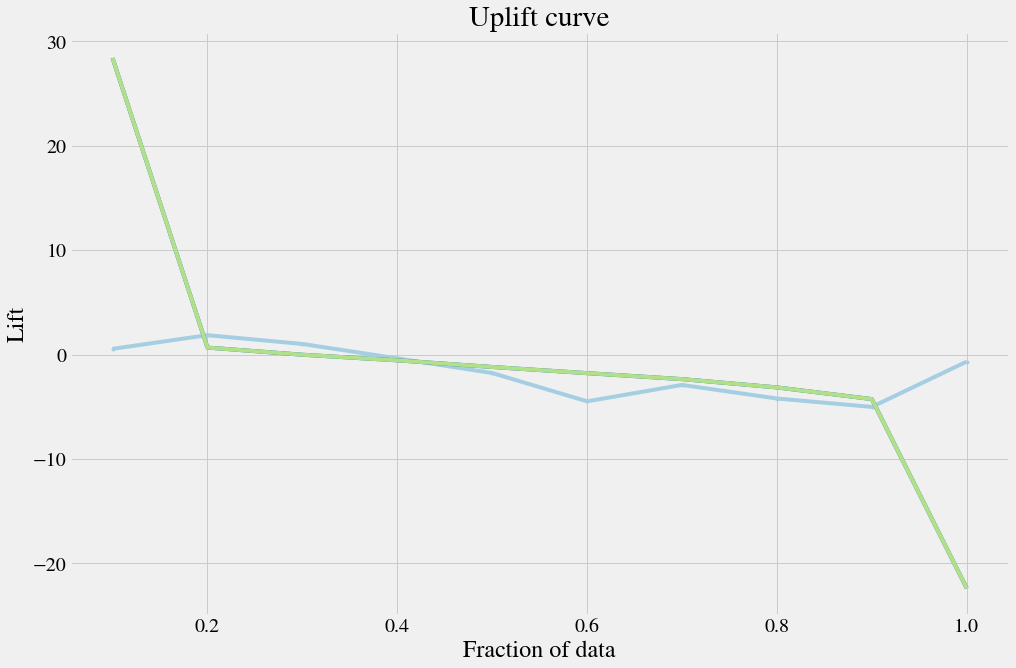

In [102]:
upeval.plot_uplift()
plt.plot(*pylift_utils.plot_uplift_prediction(upeval=upeval, n_bins=10))

Для модели на R-learner прогнозы оказались ближе к реальности, но имеются проблемы на концах.  
В целом можно считать, что оценка несмещенная.